# CEO-REQUEST CHALLENGE

> Should Olist remove underperforming sellers from its marketplace?

Problem statement

To analyse the impact of removing the worse sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of sellers to remove that maximizes Olist's profit margin

In [1]:
# Write down a detailed strategy (step by step) to create the DataFrame you need for step 1
# Think about how to re-use or update the logic you have already coded in your `olist` package

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate your source code in `seller.py` - how was the mean `review_score` per seller computed? Can you imagine a way to amend your code  to compute `cost_of_reviews` in the same process? 
</details>


Your turn!

In [2]:
# Keep this notebook tidy, you will present it orally to Olist CEO on Friday afternoon

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from olist.seller import Seller
from olist.data import Olist 

%load_ext autoreload
%autoreload 2

In [4]:
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307,2370.307,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800,95.800,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999,87.999,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201,96.799,-3.201


In [5]:
# REVENUE

# Monthly subscription
# (Date of last sale - date of first sale) * 80
number_of_months_on_olist = (sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, 'M')
sellers['months_on_olist'] = number_of_months_on_olist.map(lambda x: 1 if x < 1 else np.ceil(x))

sellers['revenue'] = sellers.months_on_olist * 80 + sellers.sales * 0.1

# COST
# cost_of_reviews gives the cost associated with all the bad reviews received by each seller
# Cost to Olist in Brazilian Reals (BRL) and according to number of stars in review based on following table:   
# 1_star: 100,  2_stars: 50, 3_stars: 40 4_stars: 0, 5_stars: 0
sellers['cost_of_review'] = sellers.review_score.map({ 1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
sellers['cost_of_reviews'] = sellers.groupby('seller_id', as_index=False).sum().cost_of_review

In [6]:
sellers.head(10)


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs,cost_of_review
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,...,0.0,3,3,1.000000,218.70,341.870,201.870,341.870,201.870,40.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,...,0.0,40,41,1.025000,11703.07,2290.307,2050.307,2370.307,2130.307,NaN
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,...,0.0,1,1,1.000000,158.00,15.800,15.800,95.800,95.800,0.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,...,0.0,1,1,1.000000,79.99,7.999,7.999,87.999,87.999,0.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,...,0.0,1,1,1.000000,167.99,16.799,-83.201,96.799,-3.201,100.0
5,c240c4061717ac1806ae6ee72be3533b,rio de janeiro,RJ,0.000000,6.056956,2018-05-08 17:55:23,2018-05-08 17:55:23,1.0,0.000000,0.000000,...,0.0,1,1,1.000000,59.90,5.990,5.990,85.990,85.990,0.0
6,e49c26c3edfa46d227d5121a6b6e4d37,brejao,PE,0.000000,11.653801,2017-02-04 19:31:42,2018-07-25 14:30:27,18.0,0.057143,0.742857,...,0.0,35,36,1.028571,3654.25,1805.425,1475.425,1805.425,1475.425,NaN
7,1b938a7ec6ac5061a66a3766e0e75f90,penapolis,SP,0.000000,11.376438,2017-09-23 17:24:32,2018-08-18 19:09:29,11.0,0.100000,0.600000,...,0.0,30,33,1.100000,3987.60,1278.760,978.760,1278.760,978.760,NaN
8,768a86e36ad6aae3d03ee3c6433d61df,sao paulo,SP,0.000000,5.081859,2018-06-19 12:18:24,2018-08-24 03:15:18,3.0,0.000000,0.705882,...,0.0,17,17,1.000000,587.46,218.746,178.746,298.746,258.746,NaN
9,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.000000,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,20.0,0.085561,0.652406,...,0.0,187,192,1.026738,74004.62,8920.462,6700.462,9000.462,6780.462,NaN


Text(0.5, 1.0, 'Distribution of Seller Contribution to Olist Revenues')

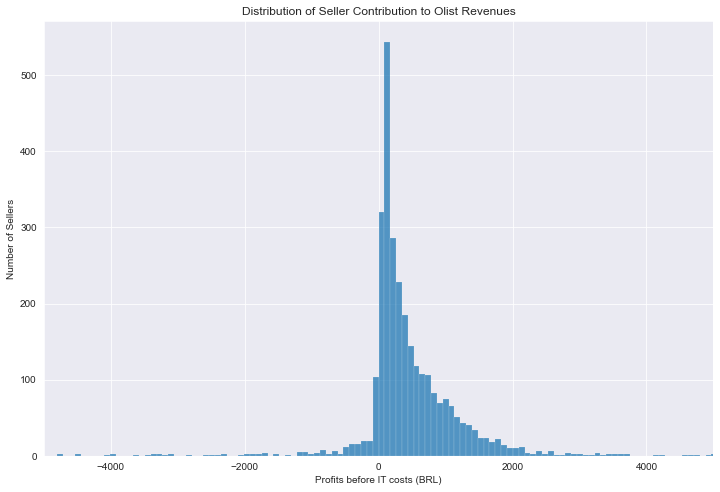

In [31]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
ax = sns.histplot(sellers.profits_before_it_costs)
ax.set_xlim(xmin=-5000, xmax=5000)
ax.set_xlabel('Profits before IT costs (BRL)')
ax.set_ylabel('Number of Sellers')
ax.set_title('Distribution of Seller Contribution to Olist Revenues')

In [34]:
sellers['profits_before_it_costs'].describe()

count     2970.000000
mean       424.055631
std       1274.295160
min     -22419.517000
25%         93.000000
50%        285.790500
75%        720.593750
max      17967.605000
Name: profits_before_it_costs, dtype: float64

In [35]:
# 75% of sellers on Olist platform contribute less than ~720 BRL (~USD=138) to Olist revenues

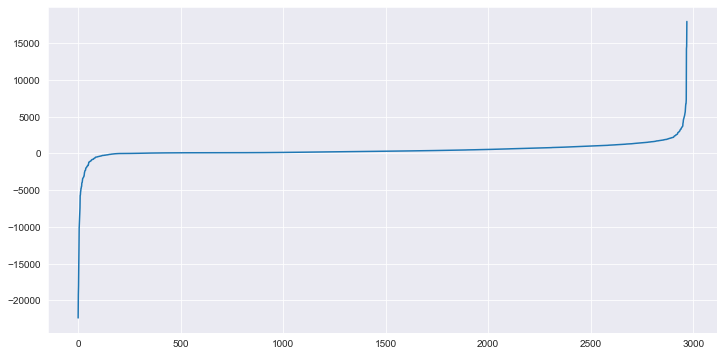

In [42]:
sellers.sort_values('profits_before_it_costs', ignore_index=True).profits_before_it_costs.plot(figsize=(12,6));



In [43]:
##STEP 2: SORT SELLERS
'''Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, 
compute the financial impact it would have made had they never been accepted on the platform. 
We may find an optimal number of sellers to remove that maximizes Olist's profit margin'''


"Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, \ncompute the financial impact it would have made had they never been accepted on the platform. \nWe may find an optimal number of sellers to remove that maximizes Olist's profit margin"

In [44]:
sellers.sort_values('profits_before_it_costs', ignore_index=True, inplace=True, ascending=False)
sellers.head(5)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,revenues,profits,revenue,profits_before_it_costs,cost_of_review,accumulated_profits,accumulated_orders,it_cost,it_unit_cost,olist_profits
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.097765,0.558659,...,23237.605,17967.605,23237.605,17967.605,NaN,17967.605,358,0.529785,NaN,17967.075215
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,22.0,0.104167,0.627976,...,19323.187,14523.187,19403.187,14603.187,NaN,32570.792,694,0.737629,0.207844,14602.449371
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.088889,0.673504,...,21004.203,14254.203,21004.203,14254.203,NaN,46824.995,1279,1.001367,0.263738,14253.201633
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,8808.455,7288.455,8808.455,7288.455,NaN,54113.450,1445,1.064368,0.063001,7287.390632
4,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,20.0,0.085561,0.652406,...,8920.462,6700.462,9000.462,6780.462,NaN,60893.912,1632,1.131145,0.066776,6779.330855


In [11]:
#CALC Cumulative sum column of profits to Olist from seller
sellers['accumulated_profits'] = sellers['profits_before_it_costs'].cumsum()
sellers.tail(300)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs,cost_of_review,accumulated_profits
2670,0b3f27369a4d8df98f7eb91077e438ac,aruja,SP,0.0,7.161655,2017-11-13 15:31:35,2017-11-22 18:49:01,1.0,0.000000,0.333333,...,2,3,1.500000,146.51,14.651,-65.349,94.651,14.651,NaN,1572553.808
2671,ef990a83bbea832f36ebe81376335aa8,joinville,SC,0.0,16.851660,2017-11-27 20:39:25,2018-08-12 18:55:15,9.0,0.232558,0.441860,...,43,44,1.023256,4642.59,1104.259,-65.741,1184.259,14.259,NaN,1572568.067
2672,f19516b9ff26bfeb091b30108db4ddbd,artur nogueira,SP,0.0,10.648129,2017-08-17 22:04:58,2017-11-14 21:27:34,3.0,0.600000,0.400000,...,5,5,1.000000,727.60,312.760,12.760,312.760,12.760,NaN,1572580.827
2673,22c32ec35d0116ef02c281798a25bf8b,maringa,PR,0.0,9.717814,2018-02-01 02:35:54,2018-02-22 19:30:24,1.0,0.000000,0.250000,...,4,6,1.500000,119.58,91.958,11.958,91.958,11.958,NaN,1572592.785
2674,1b65c144b17e607c0f37f10bb7dfec8d,rio do sul,SC,0.0,8.770838,2018-04-24 18:20:52,2018-06-29 11:51:27,3.0,0.600000,0.000000,...,5,5,1.000000,1109.50,270.950,-69.050,350.950,10.950,50.0,1572603.735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118770,0.567338,...,943,1018,1.079533,17535.69,2553.569,-13066.431,2553.569,-13066.431,NaN,1335110.855
2966,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,13.0,0.116827,0.524847,...,1146,1204,1.050611,37177.52,4677.752,-16032.248,4757.752,-15952.248,NaN,1319158.607
2967,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.117277,0.581808,...,1706,1819,1.066237,104288.42,11948.842,-18051.158,11948.842,-18051.158,NaN,1301107.449
2968,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.147640,0.476948,...,1806,2009,1.112403,200472.92,21647.292,-19242.708,21647.292,-19242.708,NaN,1281864.741


In [12]:
#Total profits
profits = sellers['accumulated_profits']
profits.iloc[-1]

1259445.2239999846

In [13]:
#Profits per number of sellers removed [DO AFTER FACTOR IN IT COSTS]


In [14]:
sellers.head(5)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs,cost_of_review,accumulated_profits
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.097765,0.558659,...,358,410,1.145251,222776.05,23237.605,17967.605,23237.605,17967.605,NaN,17967.605
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,22.0,0.104167,0.627976,...,336,340,1.011905,176431.87,19323.187,14523.187,19403.187,14603.187,NaN,32570.792
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.088889,0.673504,...,585,586,1.001709,194042.03,21004.203,14254.203,21004.203,14254.203,NaN,46824.995
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,166,175,1.054217,79284.55,8808.455,7288.455,8808.455,7288.455,NaN,54113.450
4,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,20.0,0.085561,0.652406,...,187,192,1.026738,74004.62,8920.462,6700.462,9000.462,6780.462,NaN,60893.912


In [15]:
#IT Costs 
#Proportionality coefficient(B) of 0.028 based on integral of B*(n_orders)**1/2 = 500000
sellers['accumulated_orders'] = sellers['n_orders'].cumsum()
sellers['it_cost'] = (sellers['accumulated_orders']**0.5)*0.028
sellers.tail(5)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs,cost_of_review,accumulated_profits,accumulated_orders,it_cost
2965,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118770,0.567338,...,1.079533,17535.69,2553.569,-13066.431,2553.569,-13066.431,NaN,1335110.855,93332,8.554080
2966,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,13.0,0.116827,0.524847,...,1.050611,37177.52,4677.752,-16032.248,4757.752,-15952.248,NaN,1319158.607,94478,8.606437
2967,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.117277,0.581808,...,1.066237,104288.42,11948.842,-18051.158,11948.842,-18051.158,NaN,1301107.449,96184,8.683793
2968,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.147640,0.476948,...,1.112403,200472.92,21647.292,-19242.708,21647.292,-19242.708,NaN,1281864.741,97990,8.764939
2969,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,19.0,0.127957,0.510215,...,1.099784,123304.83,13770.483,-22499.517,13850.483,-22419.517,NaN,1259445.224,99844,8.847468


In [16]:
#IT Unit Cost

sellers['it_unit_cost'] = sellers['it_cost'].diff()




In [17]:
#Profits per number of sellers removed [DO AFTER FACTOR IN IT COSTS]
sellers['olist_profits'] = sellers['profits_before_it_costs'] - sellers['it_cost']
sellers.loc[2680:2690]

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,revenues,profits,revenue,profits_before_it_costs,cost_of_review,accumulated_profits,accumulated_orders,it_cost,it_unit_cost,olist_profits
2680,aded58c8142dedc5494a81f948431fab,rio de janeiro,RJ,0.000000,8.000819,2018-04-01 20:30:16,2018-04-24 17:13:50,1.0,0.250000,0.500000,...,108.950,8.950,108.950,8.950,NaN,1572662.404,59912,6.853540,0.000229,2.096460
2681,a17f621c590ea0fab3d5d883e1630ec6,sorocaba,SP,0.000000,11.659324,2017-03-23 22:25:18,2018-04-07 02:47:52,13.0,0.153846,0.584615,...,1237.858,-72.142,1317.858,7.858,NaN,1572670.262,59977,6.857257,0.003717,1.000743
2682,94c49f20a123aeb9360dbf80ff912bf6,sorocaba,SP,0.000000,14.152438,2017-05-24 03:03:03,2017-06-06 13:15:14,1.0,0.333333,0.666667,...,27.775,-72.225,107.775,7.775,NaN,1572678.037,59980,6.857428,0.000171,0.917572
2683,557f22c76691849db52d2abccf0015d0,morrinhos,GO,0.000000,14.304741,2017-05-09 13:30:56,2017-09-13 00:15:15,5.0,0.230769,0.076923,...,406.586,-73.414,486.586,6.586,NaN,1572684.623,59993,6.858171,0.000743,-0.272171
2684,984c273121e743dd14767befe6cb17f5,americana,SP,0.000000,33.850255,2017-11-25 20:34:42,2017-11-25 20:34:42,1.0,1.000000,0.000000,...,25.960,-74.040,105.960,5.960,100.0,1572690.583,59994,6.858228,0.000057,-0.898228
2685,bdb3edbaee43a761e2d4f258dc08f348,lencois paulista,SP,0.000000,11.946273,2017-11-21 22:29:21,2017-12-18 13:29:35,1.0,0.200000,0.400000,...,105.950,5.950,105.950,5.950,NaN,1572696.533,59999,6.858514,0.000286,-0.908514
2686,6f1a1263039c76e68f40a8e536b1da6a,sao paulop,SP,3.601171,25.076549,2017-09-18 00:50:09,2018-01-15 15:31:43,4.0,0.750000,0.000000,...,345.639,5.639,345.639,5.639,NaN,1572702.172,60003,6.858743,0.000229,-1.219743
2687,7f35f9daf223da737b78738fbae4d977,valinhos,SP,0.000000,7.866502,2018-06-18 06:09:34,2018-07-05 16:11:25,1.0,0.200000,0.600000,...,105.200,5.200,105.200,5.200,0.0,1572707.372,60008,6.859029,0.000286,-1.659029
2688,95b293867b5862941c9cd74f756a3c68,sao paulo,SP,6.717900,21.464145,2017-11-27 11:54:56,2018-02-22 10:15:39,3.0,0.333333,0.555556,...,304.810,4.810,304.810,4.810,NaN,1572712.182,60017,6.859543,0.000514,-2.049543
2689,d1a5cc844736958c11b8efab9a2b4c87,curitiba,PR,18.387951,30.294271,2017-10-23 13:25:52,2017-10-23 13:25:52,1.0,1.000000,0.000000,...,23.760,-76.240,103.760,3.760,100.0,1572715.942,60018,6.859600,0.000057,-3.099600


<AxesSubplot:>

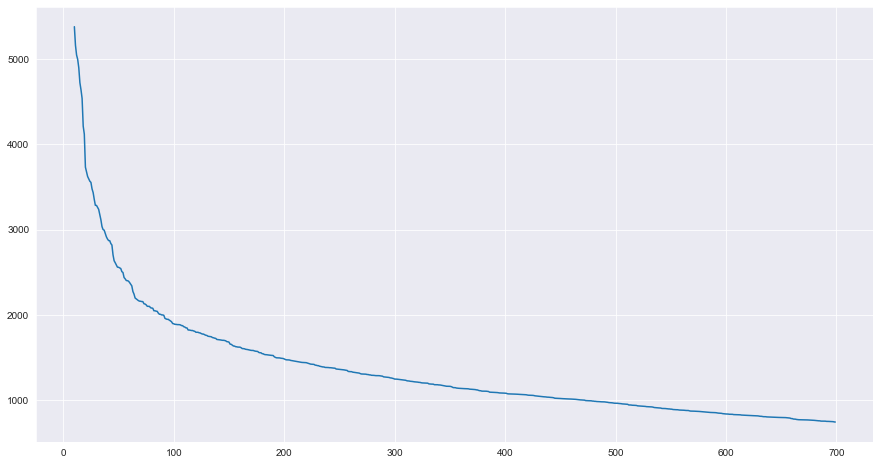

In [18]:
sellers['olist_profits'][10:700].plot(figsize=(15,8))

In [19]:
sellers.loc[50:100, :]

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,revenues,profits,revenue,profits_before_it_costs,cost_of_review,accumulated_profits,accumulated_orders,it_cost,it_unit_cost,olist_profits
50,712e6ed8aa4aa1fa65dab41fed5737e4,videira,SC,0.0,23.799677,2017-02-09 15:05:08,2018-05-19 18:18:59,16.0,0.225000,0.412500,...,5181.500,2481.500,5261.500,2561.500,NaN,235512.882,9218,2.688292,0.011544,2558.811708
51,b94cc9f10ddc85e4ba73a6f7974e7101,macae,RJ,0.0,10.580454,2017-11-02 09:45:18,2018-06-12 17:11:38,8.0,0.128205,0.743590,...,3094.610,2474.610,3174.610,2554.610,NaN,238067.492,9257,2.693973,0.005681,2551.916027
52,d03698c2efd04a549382afa6623e27fb,ilheus,BA,0.0,15.604987,2016-10-07 22:59:23,2018-07-31 21:00:09,22.0,0.055556,0.666667,...,2646.547,2546.547,2646.547,2546.547,NaN,240614.039,9275,2.696590,0.002618,2543.850410
53,87b740daf17b5d1be335a64164ec6842,suzano,SP,0.0,18.169685,2016-10-07 10:16:33,2018-03-15 16:11:12,18.0,0.307692,0.230769,...,2829.987,2429.987,2909.987,2509.987,NaN,243124.026,9288,2.698480,0.001889,2507.288520
54,a1043bafd471dff536d0c462352beb48,ilicinea,MG,0.0,13.586723,2017-02-14 10:55:10,2018-08-25 11:15:09,19.0,0.090529,0.594708,...,11630.116,2420.116,11710.116,2500.116,NaN,245624.142,10006,2.800840,0.102360,2497.315160
55,d50d79cb34e38265a8649c383dcffd48,sao paulo,SP,0.0,13.159799,2016-10-08 19:55:50,2018-08-10 11:05:13,23.0,0.042857,0.528571,...,3061.242,2361.242,3141.242,2441.242,NaN,248065.384,10076,2.810620,0.009780,2438.431380
56,7901646fdd36a55f564ffaf2dbccaaf7,rio de janeiro,RJ,0.0,9.877081,2017-03-02 20:05:15,2018-08-23 00:25:21,18.0,0.090909,0.772727,...,2625.708,2425.708,2625.708,2425.708,NaN,250491.092,10098,2.813687,0.003067,2422.894313
57,9de4643a8dbde634fe55621059d92273,joinville,SC,0.0,15.001744,2017-01-13 15:25:21,2018-02-21 16:15:59,14.0,0.041667,0.722222,...,2796.034,2326.034,2876.034,2406.034,NaN,252897.126,10170,2.823700,0.010013,2403.210300
58,989becdce12ebc39863c2bceab6f3ca1,curitiba,PR,0.0,13.739217,2016-10-07 22:59:53,2018-07-26 19:35:16,22.0,0.055556,0.777778,...,2544.088,2404.088,2544.088,2404.088,NaN,255301.214,10188,2.826197,0.002498,2401.261803
59,dc317f341ab0e22f39acbd9dbf9b4a1f,cachoeirinha,RS,0.0,12.163012,2017-01-18 14:01:22,2018-07-01 17:55:13,18.0,0.163636,0.654545,...,3258.840,2318.840,3338.840,2398.840,NaN,257700.054,10243,2.833816,0.007618,2396.006184


In [20]:
sellers['n_orders'].sort_values()

2299       1
2140       1
2417       1
2416       1
2415       1
        ... 
2906    1314
2964    1404
2967    1706
2968    1806
2969    1854
Name: n_orders, Length: 2970, dtype: int64

# Recommendation: 

## Remove poorest performing sellers on Olist platform for immediate profit increase

## Profit Analysis

- 280 poorest-performing sellers have negative impact on profits
- Top 100 highest performing sellers comprise bulk of profits

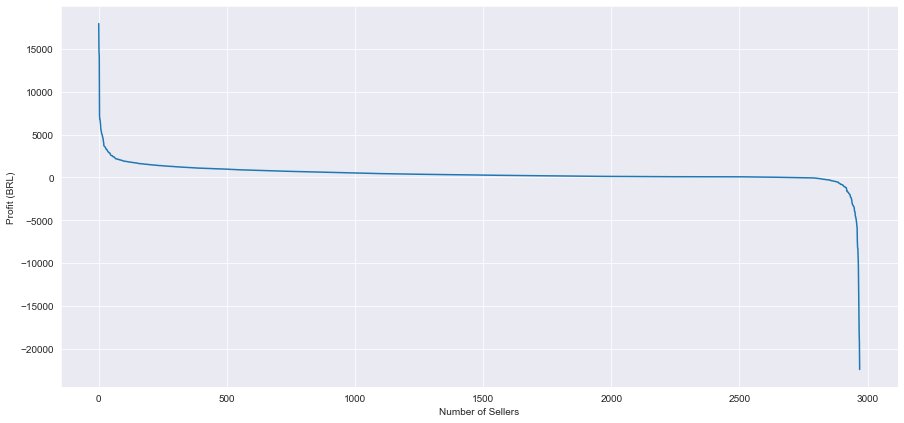

In [21]:
sellers['olist_profits'].plot(figsize=(15,7))
plt.xlabel('Number of Sellers')
plt.ylabel('Profit (BRL)')
plt.show()


## Profit Analysis

- Immediate profit increase of 320K BRL

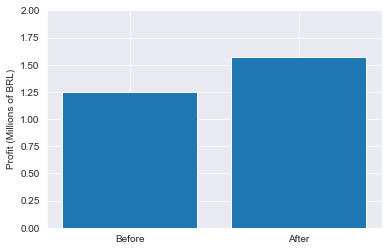

In [22]:
x_values = ['Before', 'After']
y_values = [1.25, 1.57]
plt.bar(x_values, y_values)
plt.ylabel('Profit (Millions of BRL)')
plt.ylim(0, 2)
plt.show()


## IT Cost Concerns 

- Increase in marginal costs due to drop in sellers negligible
- Some poorest-performing sellers contribute to larger share of IT cost burden


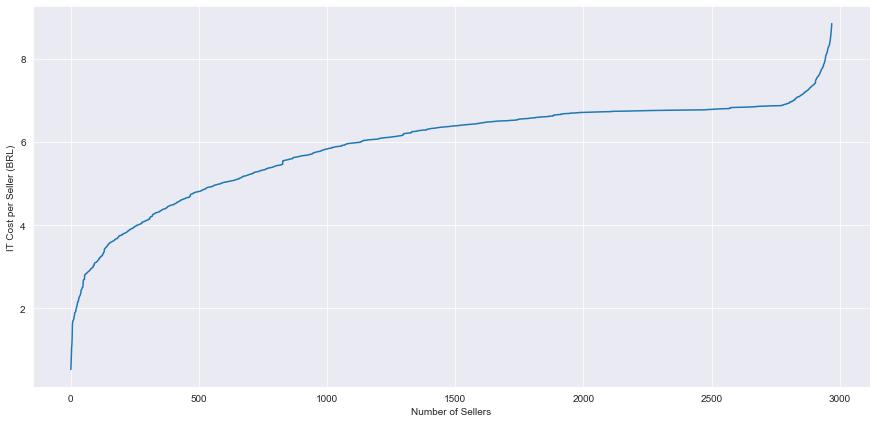

In [23]:
sellers['it_cost'].plot(figsize=(15,7))
plt.xlabel('Number of Sellers')
plt.ylabel('IT Cost per Seller (BRL)')
plt.show()


<AxesSubplot:>

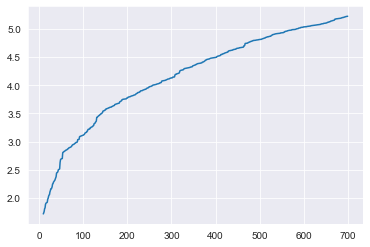

In [24]:
sellers['it_cost'][10:700].plot()

TypeError: 'function' object is not subscriptable

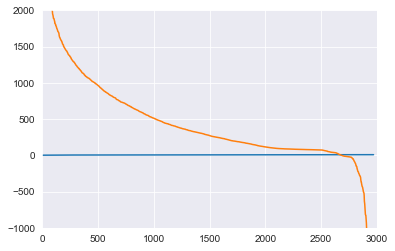

In [25]:
ax1 = sellers['it_cost'].plot()
ax1.set(xlim=[0,3000], ylim=[-1000,2000])

ax2 = sellers['olist_profits'].plot()
ax2.set(xlim=[0,3000], ylim=[-1000,2000])
plt.xlabel['']




## Areas to Explore Further

- Evaluate whether can improve average seller performance
- Explore reviews for cause of dissatisfaction